In [1]:
import sqlite3 as lite
import os
import sys
import numpy as np
import collections
sys.path.insert(0, '../../scripts/')
jupyter_directory = os.getcwd()
from IPython.display import Image
import matplotlib.pyplot as plt
from collections import OrderedDict
import os
from pyne.material import Material

/Users/13b/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: QAWarning: pyne.data is not yet QA compliant.
  return f(*args, **kwds)
/Users/13b/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: QAWarning: pyne.material is not yet QA compliant.
  return f(*args, **kwds)


In [2]:
import analysis as an

In [3]:
# metrics to get
# does it transition?
# pu inventory
# raffinate
# lwr unf reprocessed
# reprocessing throughput
# unreprocessed lwr amount

In [4]:
# get isotopics for input and output recipe
def get_element_content(cur, commodity, z):
    
    query = cur.execute('SELECT * FROM transactions '
                        'INNER JOIN resources ON '
                        'resources.resourceid = transactions.resourceid '
                        'WHERE commodity = "%s"' %commodity).fetchall()
    for i in query:
        qualid = i['qualid']
        break
    query = cur.execute('SELECT NucId, MassFrac FROM compositions '
                        'WHERE qualid = %i' %qualid).fetchall()
    el_content = 0
    for row in query:
        if row['NucId'] // 1e7 == z:
            el_content += row['MassFrac']
    return el_content


In [5]:
def metric_solver(cur):
    output_dict = OrderedDict({})
    #lwr_pu = get_element_content(cur, 'uox_waste', 94)
    lwr_pu = 0.01260317036747676
    #sfr_pu = get_element_content(cur, 'sfr_fuel_legacy', 94)
    sfr_pu = 0.14983784204641132
    #sfr_used_pu = get_element_content(cur, 'sfr_used', 94)
    sfr_used_pu = 0.14624442551485697
    #blanket_used_pu = get_element_content(cur, 'blanket_used', 94)
    blanket_used_pu = 0.053485218171692765
    try:
        legacy_pu = get_element_content(cur, 'pre_2013_unf', 94)
        legacy_pu = 0.011819328439342202
    except:
        print('This one does not have legacy pu')
    
    # pu generated
    storage_id = an.get_agent_ids(cur, 'storage')
    rep_id = an.get_agent_ids(cur, 'separations')
    lwr_fuel_out = an.facility_commodity_flux(cur, storage_id, ['uox_waste'], False, True)
    sfr_fuel_out = an.facility_commodity_flux(cur, storage_id, ['sfr_used'], False, True)
    blanket = an.facility_commodity_flux(cur, storage_id, ['blanket_used'], False, True)
    legacy = an.facility_commodity_flux(cur, rep_id, ['pre_2013_unf'], False, True)
    if len(legacy['pre_2013_unf']) == 0:
        print('This one does not have legacy pu')
    pu_generated = ((lwr_pu * np.array(lwr_fuel_out['uox_waste'])) +
                    (np.array(sfr_fuel_out['sfr_used']) * sfr_used_pu) +
                    (np.array(blanket['blanket_used']) * blanket_used_pu))
    try:
        pu_generate += np.array(legacy['pre_2013_unf']) * legacy_pu
    except:
        print('I TOLD YOU NO LEGACY')

    # pu used
    mixer_id = an.get_agent_ids(cur, 'mixer')
    sfr_fuel_in = an.facility_commodity_flux(cur, mixer_id, ['sfr_fuel_new', 'sfr_fuel_legacy'], True, True)
    total_sfr_fuel_in = np.array(sfr_fuel_in['sfr_fuel_new']) + np.array(sfr_fuel_in['sfr_fuel_legacy'])
    pu_used = (total_sfr_fuel_in * sfr_pu)
    
    # lwr reprocessed
    legacy_sfr = np.array(sfr_fuel_in['sfr_fuel_legacy'])
    legacy_pu = legacy_sfr * sfr_pu
    legacy_lwr_reprocessed = legacy_pu / lwr_pu
    print('LEGACY LWR REPROCESSED: %f' %legacy_lwr_reprocessed[-1])
    output_dict['lwr UNF reprocessed'] = legacy_lwr_reprocessed[-1]
    
    # unreprocessed lwr amount
    lwr_amount = lwr_fuel_out['uox_waste'][-1]
    try:
        lwr_amount += legacy['pre_2013_unf'][-1]
    except:
        print('NO LEGACY')
    unreprocessed_lwr = lwr_amount - legacy_lwr_reprocessed[-1]
    print('UNREPROCESSED LWR: %f' %unreprocessed_lwr)
    output_dict['unreprocessed lwr'] = unreprocessed_lwr
    
    # sfr reprocessing throughput
    new_sfr = np.array(sfr_fuel_in['sfr_fuel_new'])
    new_sfr_reprocesed = new_sfr * sfr_pu / sfr_used_pu
    reprocessing_throughput = new_sfr_reprocesed + legacy_lwr_reprocessed
    print('SFR UNF REPROCESSED: %f' %new_sfr_reprocesed[-1])
    output_dict['sfr UNF reprocessed'] = new_sfr_reprocesed[-1]

    # raffinate
    sink_id = an.get_agent_ids(cur, 'sink')
    raffinate = an.facility_commodity_flux(cur, sink_id, ['reprocess_waste'], False, True)
    output_dict['raffinate'] = raffinate['reprocess_waste'][-1]
    print('RAFFINATE: %f' %raffinate['reprocess_waste'][-1])

    raffinate = an.facility_commodity_flux_isotopics(cur, sink_id, ['reprocess_waste'], False, True)
    comp_dict = {}
    for key, value in raffinate.items():
        comp_dict[key] = value[-1]
    z = Material(comp_dict)

    output_dict['decay heat'] = np.nansum(list(dict(z.decay_heat()).values()))
    output_dict['activity'] = np.nansum(list(dict(z.activity()).values()))
    print('decay heat: %f' %output_dict['decay heat'])
    print('activity: %f' %output_dict['activity'])

    # get them metrics
    pu_inventory = pu_generated - pu_used
    output_dict['pu inventory'] = pu_inventory[-1]
    print('PU INVENTORY: %f' %pu_inventory[-1])
    return output_dict

In [6]:
def metric_solver2(cur):
    output_dict = OrderedDict({})
    #lwr_pu = get_element_content(cur, 'uox_waste', 94)
    lwr_pu = 0.01260317036747676
    #sfr_pu = get_element_content(cur, 'sfr_fuel_legacy', 94)
    sfr_pu = 0.14983784204641132
    #sfr_used_pu = get_element_content(cur, 'sfr_used', 94)
    sfr_used_pu = 0.14624442551485697
    #blanket_used_pu = get_element_content(cur, 'blanket_used', 94)
    blanket_used_pu = 0.053485218171692765
    try:
        legacy_pu = get_element_content(cur, 'pre_2013_unf', 94)
        legacy_pu = 0.011819328439342202
    except:
        print('This one does not have legacy pu')

    # natural uranium usage
    output_dict['natural uranium'] = an.nat_u_timeseries(cur, True)[-1]
    
    # average reprocessing
    mixer_id = an.get_agent_ids(cur, 'mixer')
    sfr_fuel_in = an.facility_commodity_flux(cur, mixer_id, ['sfr_fuel_new', 'sfr_fuel_legacy'], True, True)
    legacy_sfr = np.array(sfr_fuel_in['sfr_fuel_legacy'])
    legacy_pu = legacy_sfr * sfr_pu
    legacy_lwr_reprocessed = legacy_pu / lwr_pu
    # average from 2030 - 2120 (90 years)
    avg_lwr_reprocessed = legacy_lwr_reprocessed[-1] / 90
    
    new_sfr = np.array(sfr_fuel_in['sfr_fuel_new'])
    new_sfr_reprocessed = new_sfr * sfr_pu / sfr_used_pu
    avg_sfr_reprocessed = new_sfr_reprocessed[-1] / 90
    output_dict['lwr annual reprocessing'] = avg_lwr_reprocessed
    output_dict['sfr annual reprocessing'] = avg_sfr_reprocessed
    output_dict['total annual reprocessing'] = avg_lwr_reprocessed + avg_sfr_reprocessed  
    
    # raffinate
    sink_id = an.get_agent_ids(cur, 'sink')
    raffinate = an.facility_commodity_flux(cur, sink_id, ['reprocess_waste'], False, True)
    output_dict['raffinate'] = raffinate['reprocess_waste'][-1]
    print('RAFFINATE: %f' %raffinate['reprocess_waste'][-1])

    raffinate = an.facility_commodity_flux_isotopics(cur, sink_id, ['reprocess_waste'], False, True)
    comp_dict = {}
    for key, value in raffinate.items():
        comp_dict[key] = value[-1]
    z = Material(comp_dict)
    
    return output_dict

In [55]:
import math
def metric_solver3(cur):
    output_dict = OrderedDict({})
    #lwr_pu = get_element_content(cur, 'uox_waste', 94)
    lwr_pu = 0.01260317036747676
    #sfr_pu = get_element_content(cur, 'sfr_fuel_legacy', 94)
    sfr_pu = 0.14983784204641132
    #sfr_used_pu = get_element_content(cur, 'sfr_used', 94)
    sfr_used_pu = 0.14624442551485697
    #blanket_used_pu = get_element_content(cur, 'blanket_used', 94)
    blanket_used_pu = 0.053485218171692765
    try:
        legacy_pu = get_element_content(cur, 'pre_2013_unf', 94)
        legacy_pu = 0.011819328439342202
    except:
        print('This one does not have legacy pu')

    # raffinate
    sink_id = an.get_agent_ids(cur, 'sink')
    raffinate = an.facility_commodity_flux_isotopics(cur, sink_id, ['reprocess_waste'], False, True)
    comp_dict = {}
    for key, value in raffinate.items():
        comp_dict[key] = value[-1]
    z = Material(comp_dict)
    activity = z.activity()
    dec_heat = z.decay_heat()
    tot_act = 0
    tot_dec = 0
    for key, val in activity.items():
        if str(key)[-1] == '1' or math.isnan(val):
            tot_act = tot_act
        else:
            # pyne understands it in grams, but we are in tons [total ]
            tot_act += val * 1e6 / (3.7e10)
    for key, val in dec_heat.items():
        if str(key)[-1] == '1' or math.isnan(val):
            tot_dec = tot_dec
        else:
            # pyne understands it in grams, but we are in tons [total MW]
            tot_dec += val * 1e6
    
    output_dict['decay heat'] = tot_dec
    output_dict['activity'] = tot_act
    print(tot_dec)
    print(tot_act)
    
    return output_dict

In [56]:
# get all output files
file_list = []
for root, dirs, files in os.walk('./output/sweep'):
    for file in files:
        if file.endswith('.sqlite'):
            file_list.append(os.path.join(root, file))
print(file_list)

['./output/sweep/2030_005_growth_no.sqlite', './output/sweep/2030_005_growth_precise.sqlite', './output/sweep/2030_005_growth_recipe.sqlite', './output/sweep/2030_015_growth_no.sqlite', './output/sweep/2030_015_growth_precise.sqlite', './output/sweep/2030_015_growth_recipe.sqlite', './output/sweep/2030_01_growth_no.sqlite', './output/sweep/2030_01_growth_precise.sqlite', './output/sweep/2030_01_growth_recipe.sqlite', './output/sweep/2030_0_growth_no.sqlite', './output/sweep/2030_0_growth_precise.sqlite', './output/sweep/2030_0_growth_recipe.sqlite', './output/sweep/2035_005_growth_no.sqlite', './output/sweep/2035_005_growth_precise.sqlite', './output/sweep/2035_005_growth_recipe.sqlite', './output/sweep/2035_015_growth_no.sqlite', './output/sweep/2035_015_growth_precise.sqlite', './output/sweep/2035_015_growth_recipe.sqlite', './output/sweep/2035_01_growth_no.sqlite', './output/sweep/2035_01_growth_precise.sqlite', './output/sweep/2035_01_growth_recipe.sqlite', './output/sweep/2035_0_g

In [69]:
# do work
f = open('./output/metrics3', 'w')
big_dict = {}
for file in file_list:
    if file != file_list[0]:
        f = open('./output/metrics3', 'a+')
    outputname = '%s' %(file.replace('./output/sweep/', '').replace('.sqlite', ''))
    print('DOING %s' %outputname)
    cur = an.get_cursor(file)
    out_dict = metric_solver3(cur)
    big_dict[outputname] = out_dict
    f.write('%s\n======================' %outputname)
    for key, val in out_dict.items():
        write_string = '%s:\t%s\ttons' %(key, str(val))
        f.write(write_string)
    f.write('\n')
    f.close()


DOING 2030_005_growth_no
This one does not have legacy pu
852.7749976111552
200926015652.37927
DOING 2030_005_growth_precise
496.6296458979462
130591268104.88997
DOING 2030_005_growth_recipe
490.85983983555457
129511672119.82376
DOING 2030_015_growth_no
This one does not have legacy pu
719.7980510735232
189240192439.24896
DOING 2030_015_growth_precise
1668.900002057237
399385791156.6375
DOING 2030_015_growth_recipe
1661.24507485312
397840835184.14044
DOING 2030_01_growth_no
This one does not have legacy pu
1133.5857180408977
268328901862.44223
DOING 2030_01_growth_precise
680.616966449519
181123609560.84772
DOING 2030_01_growth_recipe
1253.353896302025
299323716401.0604
DOING 2030_0_growth_no
This one does not have legacy pu
349.47833529822117
88573057350.98439
DOING 2030_0_growth_precise
398.7704768787995
101852511869.99135
DOING 2030_0_growth_recipe
657.571055847761
155813894113.95584
DOING 2035_005_growth_no
This one does not have legacy pu
425.14834000641326
106593745226.84232
DOIN

In [70]:
with open('./output/prettier_metric', 'w') as w:
    with open('./output/metrics3', 'r') as f:
        lines = f.readlines()
        for line in lines:
            if '======================' in line:
                line = line.replace('======================', '======================\n')
            if 'tons' in line:
                line = line.replace('tons', 'tons\n')
            w.write(line)


In [71]:
!cat ./output/prettier_metric

2030_005_growth_no
decay heat:	852.7749976111552	tons
activity:	200926015652.37927	tons

2030_005_growth_precise
decay heat:	496.6296458979462	tons
activity:	130591268104.88997	tons

2030_005_growth_recipe
decay heat:	490.85983983555457	tons
activity:	129511672119.82376	tons

2030_015_growth_no
decay heat:	719.7980510735232	tons
activity:	189240192439.24896	tons

2030_015_growth_precise
decay heat:	1668.900002057237	tons
activity:	399385791156.6375	tons

2030_015_growth_recipe
decay heat:	1661.24507485312	tons
activity:	397840835184.14044	tons

2030_01_growth_no
decay heat:	1133.5857180408977	tons
activity:	268328901862.44223	tons

2030_01_growth_precise
decay heat:	680.616966449519	tons
activity:	181123609560.84772	tons

2030_01_growth_recipe
decay heat:	1253.353896302025	tons
activity:	299323716401.0604	tons

2030_0_growth_no
decay heat:	349.47833529822117	tons
activity:	88573057350.98439	tons

2030_0_growth_precise
decay heat:	398.7704768787995	tons
activity:	101852511869.99135	tons

In [73]:
metric_dict = {}
with open('./output/prettier_metric', 'r') as f:
    lines = f.readlines()
    for indx,line in enumerate(lines):
        if 'growth' in line:
            z = line.split('_')
            key = str(z[0]) + '_' + str(z[1]) + '_' + str(z[-1]).replace('\n', '')
            metric_dict[key] = {'Decay Heat': lines[indx + 2],
                                'Activity': lines[indx + 3]}
            for metric, val in metric_dict[key].items():
                metric_dict[key][metric] = float(val.split()[-2])
                if 'Activity' in metric:
                    # curies
                    metric_dict[key][metric] = metric_dict[key][metric]
                if 'Heat' in metric:
                    # MW
                    metric_dict[key][metric] = metric_dict[key][metric]
                metric_dict[key][metric] = round(metric_dict[key][metric],3)


In [74]:
print(list(metric_dict.keys()))
print(list(metric_dict['2030_005_precise'].keys()))
print(metric_dict['2050_005_precise'])

['2030_005_no', '2030_005_precise', '2030_005_recipe', '2030_015_no', '2030_015_precise', '2030_015_recipe', '2030_01_no', '2030_01_precise', '2030_01_recipe', '2030_0_no', '2030_0_precise', '2030_0_recipe', '2035_005_no', '2035_005_precise', '2035_005_recipe', '2035_015_no', '2035_015_precise', '2035_015_recipe', '2035_01_no', '2035_01_precise', '2035_01_recipe', '2035_0_no', '2035_0_precise', '2035_0_recipe', '2040_005_no', '2040_005_precise', '2040_005_recipe', '2040_015_no', '2040_015_precise', '2040_015_recipe', '2040_01_no', '2040_01_precise', '2040_01_recipe', '2040_0_no', '2040_0_precise', '2040_0_recipe', '2045_005_no', '2045_005_precise', '2045_005_recipe', '2045_015_no', '2045_015_precise', '2045_015_recipe', '2045_01_no', '2045_01_precise', '2045_01_recipe', '2045_0_no', '2045_0_precise', '2045_0_recipe', '2050_005_no', '2050_005_precise', '2050_005_recipe', '2050_015_no', '2050_015_precise', '2050_015_recipe', '2050_01_no', '2050_01_precise', '2050_01_recipe', '2050_0_no',

In [65]:
from matplotlib import cm
from matplotlib.ticker import FuncFormatter
def get_3d_metric(metric_dict, metric, no=False):
    year_list = []
    rate_list = []
    metric_list = []
    for indx, year in enumerate(['2030', '2035', '2040', '2045', '2050']):
        for key, val in metric_dict.items():
            skip = False
            for failures in ['2030_01', '2030_015', '2035_015']:
                if failures in key:
                    skip = True
            if not skip:
                if year in key and 'precise' in key:
                    year_list.append(year)
                    metric_list.append(val[metric])
                    rate = float(key.split('_')[1])
                    if rate == 15:
                        rate = 1.5
                    if rate == 5:
                        rate = 0.5
                    rate_list.append(rate)
    
    #!!!!!
    dm_dy_list = []
    dm_dr_list = []
    
    dm_dr_abs = []
    dm_dy_abs = []
    year_list = [int(year) for year in year_list]
    plt.scatter(rate_list, year_list, c=metric_list, cmap='viridis', s=4500, marker='s')
    comma_fmt = FuncFormatter(lambda x, p: format(int(x), ','))
    cbar = plt.colorbar(format=comma_fmt)
    cbar.set_label('Mass [t]')
    cbar.outline.set_visible(False) 
    for indx,year in enumerate(year_list):
        r = rate_list[indx]
        mi = metric_list[indx]
        # find index for next year
        try:
            y1 = [i for i, x in enumerate(year_list) if x == year + 5]
            y2 = [i for i, x in enumerate(rate_list) if x == r]
            yi = np.intersect1d(y1, y2)[0]
            # increase ratio
            dm_dy = (metric_list[yi] - mi) / mi
            dm_dy_list.append((metric_list[yi] - mi) / mi)
            dm_dy_abs.append(metric_list[yi] - mi)
        except:
            dm_dy = 0
            dm_dy_list.append(0)
            dm_dy_abs.append(0)
            print('%i_%f Does not have next year' %(int(year), r))
        try:
            r1 = [i for i, x in enumerate(rate_list) if x == r + 0.5]
            r2 = [i for i, x in enumerate(year_list) if x == year]
            ri = np.intersect1d(r1, r2)[0]
            # increase ratio
            dm_dr = (metric_list[ri] - mi) / mi
            dm_dr_list.append((metric_list[ri] - mi) / mi)
            dm_dr_abs.append(metric_list[ri] - mi)
        except:
            dm_dr = 0
            dm_dr_list.append(0)
            dm_dr_abs.append(0)
            print("%i_%f Doesn't have a next rate" %(int(year), r))
        year = float(year)
        if dm_dy < 0:
            plt.scatter(r, year+1.3, s=dm_dy * -1000, marker=r'$\downarrow$', color='white')
        else:
            plt.scatter(r, year+1.3, s=dm_dy * 1000, marker=r'$\uparrow$', color='white')
        if dm_dr < 0:
            plt.scatter(r+0.25, year, s=dm_dr * -1000, marker=r'$\leftarrow$', color='white')
        else:
            plt.scatter(r+0.25, year, s=dm_dr * 1000, marker=r'$\rightarrow$', color='white')
    print('THE AVERAGE dm/dy: %f(%f percent) per 5 years'
          %(sum(dm_dy_abs)/len(dm_dy_abs), sum(dm_dy_list)/len(dm_dy_list) * 100))
    print('THE AVERAGE dm/dr: %f(%f percent) per 5 percent'
          %(sum(dm_dr_abs)/len(dm_dr_abs), sum(dm_dr_list)/len(dm_dr_list) * 100))
    
     
    plt.xlabel('Annual Power Demand Growth Rate [%]')
    plt.ylabel('SFR Available Year')
    plt.title(metric + ' for different US transition scenarios')
    # create legend for arrow size
    q = plt.scatter([], [], marker=r'$\uparrow$', color='blue', s=1000)
    w = plt.scatter([], [], marker=r'$\uparrow$', color='blue', s=500)
    e = plt.scatter([], [], marker=r'$\uparrow$', color='blue', s=250)
    r = plt.scatter([], [], marker=r'$\uparrow$', color='blue', s=125)
    labels = ['100%', '50%', '25%', '12.5%']
    lgd = plt.legend([q,w,e,r], labels, ncol=4, fontsize=10,
                     bbox_to_anchor=(1.1, -0.2), borderaxespad=0.)
    path = './output/sweep_images/scat_both_' + str(metric) + '.png'
    path = path.replace(' ', '_')
    plt.savefig(path, bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()
    plt.close()

In [79]:
from matplotlib import cm
from matplotlib.ticker import FuncFormatter
def get_diff_dots(metric_dict, metric, no=False):
    year_list = []
    year_recipe_list = []
    rate_list = []
    rate_recipe_list = []
    metric_list = []
    metric_recipe_list = []
    for indx, year in enumerate(['2030', '2035', '2040', '2045', '2050']):
        for key, val in metric_dict.items():
            skip = False
            for failures in ['2030_01', '2030_015', '2035_015']:
                if failures in key:
                    skip = True
            if not skip:
                if year in key and 'precise' in key:
                    year_list.append(year)
                    metric_list.append(val[metric])
                    rate = float(key.split('_')[1])
                    if rate == 15:
                        rate = 1.5
                    if rate == 5:
                        rate = 0.5
                    rate_list.append(rate)
                if year in key and 'recipe' in key:
                    year_recipe_list.append(year)
                    metric_recipe_list.append(val[metric])
                    rate = float(key.split('_')[1])
                    if rate == 15:
                        rate = 1.5
                    if rate == 5:
                        rate = 0.5
                    rate_recipe_list.append(rate)
    diff_metric_list = [x - y for x,y in zip(metric_list, metric_recipe_list)]
    
    #!!!!!
    dm_dy_list = []
    dm_dr_list = []
    
    dm_dr_abs = []
    dm_dy_abs = []
    year_list = [int(year) for year in year_list]
    plt.scatter(rate_list, year_list, c=diff_metric_list, cmap='viridis', s=4500, marker='s')
    comma_fmt = FuncFormatter(lambda x, p: format(int(x), ','))
    cbar = plt.colorbar(format=comma_fmt)
    cbar.set_label('Mass [t]')
    cbar.outline.set_visible(False) 
    for indx,year in enumerate(year_list):
        r = rate_list[indx]
        mi = metric_recipe_list[indx]
        # find index for next year
        try:
            y1 = [i for i, x in enumerate(year_list) if x == year + 5]
            y2 = [i for i, x in enumerate(rate_list) if x == r]
            yi = np.intersect1d(y1, y2)[0]
            # increase ratio
            dm_dy = (metric_list[yi] - mi) / mi
            dm_dy_list.append((metric_list[yi] - mi) / mi)
            dm_dy_abs.append(metric_list[yi] - mi)
        except:
            dm_dy = 0
            dm_dy_list.append(0)
            dm_dy_abs.append(0)
            print('%i_%f Does not have next year' %(int(year), r))
        try:
            r1 = [i for i, x in enumerate(rate_list) if x == r + 0.5]
            r2 = [i for i, x in enumerate(year_list) if x == year]
            ri = np.intersect1d(r1, r2)[0]
            # increase ratio
            dm_dr = (metric_list[ri] - mi) / mi
            dm_dr_list.append((metric_list[ri] - mi) / mi)
            dm_dr_abs.append(metric_list[ri] - mi)
        except:
            dm_dr = 0
            dm_dr_list.append(0)
            dm_dr_abs.append(0)
            print("%i_%f Doesn't have a next rate" %(int(year), r))
        year = float(year)
        if dm_dy < 0:
            plt.scatter(r, year+1.3, s=dm_dy * -1000, marker=r'$\downarrow$', color='white')
        else:
            plt.scatter(r, year+1.3, s=dm_dy * 1000, marker=r'$\uparrow$', color='white')
        if dm_dr < 0:
            plt.scatter(r+0.25, year, s=dm_dr * -1000, marker=r'$\leftarrow$', color='white')
        else:
            plt.scatter(r+0.25, year, s=dm_dr * 1000, marker=r'$\rightarrow$', color='white')
    print('THE AVERAGE dm/dy: %f(%f percent) per 5 years'
          %(sum(dm_dy_abs)/len(dm_dy_abs), sum(dm_dy_list)/len(dm_dy_list) * 100))
    print('THE AVERAGE dm/dr: %f(%f percent) per 5 percent'
          %(sum(dm_dr_abs)/len(dm_dr_abs), sum(dm_dr_list)/len(dm_dr_list) * 100))
    
     
    plt.xlabel('Annual Power Demand Growth Rate [%]')
    plt.ylabel('SFR Available Year')
    plt.title(metric + ' for different US transition scenarios')
    # create legend for arrow size
    q = plt.scatter([], [], marker=r'$\uparrow$', color='blue', s=1000)
    w = plt.scatter([], [], marker=r'$\uparrow$', color='blue', s=500)
    e = plt.scatter([], [], marker=r'$\uparrow$', color='blue', s=250)
    r = plt.scatter([], [], marker=r'$\uparrow$', color='blue', s=125)
    labels = ['100%', '50%', '25%', '12.5%']
    lgd = plt.legend([q,w,e,r], labels, ncol=4, fontsize=10,
                     bbox_to_anchor=(1.1, -0.2), borderaxespad=0.)
    path = './output/sweep_images/scat_both_' + str(metric) + '.png'
    path = path.replace(' ', '_')
    plt.savefig(path, bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()
    plt.close()

In [80]:
from matplotlib import cm
from matplotlib.ticker import FuncFormatter
def get_size_dots(metric_dict, metric, no=False):
    year_list = []
    rate_list = []
    metric_list = []
    for indx, year in enumerate(['2030', '2035', '2040', '2045', '2050']):
        for key, val in metric_dict.items():
            skip = False
            for failures in ['2030_01', '2030_015', '2035_015']:
                if failures in key:
                    skip = True
            if not skip:
                if year in key and 'precise' in key:
                    year_list.append(year)
                    metric_list.append(val[metric])
                    rate = float(key.split('_')[1])
                    if rate == 15:
                        rate = 1.5
                    if rate == 5:
                        rate = 0.5
                    rate_list.append(rate)
    year_list = [int(year) for year in year_list]
    norm_metric_list = [x * 2000 / max(metric_list) for x in metric_list]
    plt.scatter(rate_list, year_list, s=norm_metric_list, cmap='viridis')
    q = plt.scatter([], [], color='blue', s=2000)
    w = plt.scatter([], [], color='blue', s=1000)
    e = plt.scatter([], [], color='blue', s=500)
    r = plt.scatter([], [], color='blue', s=250)
    labels = [max(metric_list), max(metric_list) / 2, max(metric_list) /4, max(metric_list) / 2]
    labels = ["{:,}".format(int(x)) for x in labels]
    lgd = plt.legend([q,w,e,r], labels, loc=(1.0, 0), fontsize=30)
       
    plt.xlabel('Annual Power Demand Growth Rate [%]')
    plt.ylabel('SFR Available Year')
    plt.title(metric + ' for different US transition scenarios')
    path = './output/sweep_images/scat_size' + str(metric) + '.png'
    path = path.replace(' ', '_')
    plt.tight_layout()
    plt.savefig(path, bbox_extra_artists=(lgd, ), bbox_inches='tight',)
    plt.show()
    plt.close()

In [81]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}


<IPython.core.display.Javascript object>

2030_0.500000 Doesn't have a next rate
2035_1.000000 Doesn't have a next rate
2040_1.500000 Doesn't have a next rate
2045_1.500000 Doesn't have a next rate
2050_0.500000 Does not have next year
2050_1.500000 Does not have next year
2050_1.500000 Doesn't have a next rate
2050_1.000000 Does not have next year
2050_0.000000 Does not have next year
THE AVERAGE dm/dy: -119.423176(-16.183733 percent) per 5 years
THE AVERAGE dm/dr: 98.856235(25.353000 percent) per 5 percent


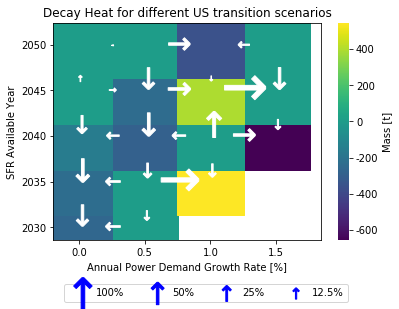

2030_0.500000 Doesn't have a next rate
2035_1.000000 Doesn't have a next rate
2040_1.500000 Doesn't have a next rate
2045_1.500000 Doesn't have a next rate
2050_0.500000 Does not have next year
2050_1.500000 Does not have next year
2050_1.500000 Doesn't have a next rate
2050_1.000000 Does not have next year
2050_0.000000 Does not have next year
THE AVERAGE dm/dy: -29775685712.809418(-18.332199 percent) per 5 years
THE AVERAGE dm/dr: 26919646933.079941(28.004885 percent) per 5 percent


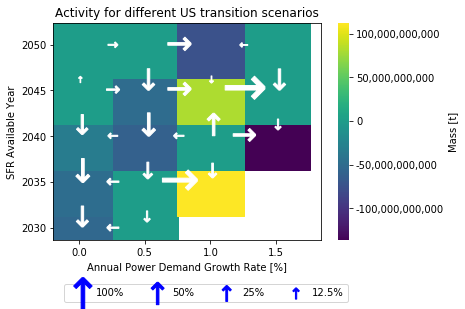

In [82]:
for key in metric_dict['2030_005_precise'].keys():
   # get_3d_metric(metric_dict, key)
    get_diff_dots(metric_dict, key)

In [47]:
cur = an.get_cursor('./output/sweep/2030_0_growth_no.sqlite')
z = cur.execute('SELECT distinct(commodity) FROM transactions').fetchall()
for row in z:
    print(row['commodity'])

natl_u
uox
tailings
uox_waste
cooled_uox
lwr_u
lwr_pu
reprocess_waste
blanket
sfr_fuel_legacy
sfr_used
blanket_used
cooled_blanket
sfr_pu
sfr_u
cooled_sfr
sfr_fuel_new
